In [762]:
import torch
from torchvision import datasets, transforms

In diesem Beispiel sehen wir uns MNIST an.
Hierbei handelt es sich um eine Datenbank aus
70000 handgeschriebenen Ziffern, davon 60000 im Trainings-
und 10000 im Testdatensatz.

In [763]:
train_set = datasets.MNIST("data", train=True, download=True,
                       transform=transforms.Compose([transforms.ToTensor()]))
test_set = datasets.MNIST("data", train=False, download=True,
                       transform=transforms.Compose([transforms.ToTensor()]))

Diesen Datensatz packen wir nun in einen passenden `DataLoader`.
Mit diesem können wir gut über Datensätze iterieren.

In [764]:
batch_size = 100

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

Das erste Element des DataLoaders sieht wie folgt aus:

In [765]:
fst_data = next(iter(train_loader))
print(fst_data)

[tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0

Betrachten beispielhaft wir die erste Ziffer.

Text(0.5, 1.0, 'Value: 5')

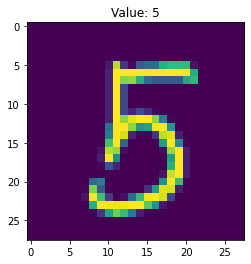

In [766]:
fst_image = fst_data[0][0]
fst_digit = fst_data[1][0].item()

import matplotlib.pyplot as plt
plt.imshow(fst_image.view(fst_image.shape[1], fst_image.shape[2]))
plt.title("Value: " + str(fst_digit))

### Logistische Regression
Nun erstellen wir die Architektur der logistischen Regression.

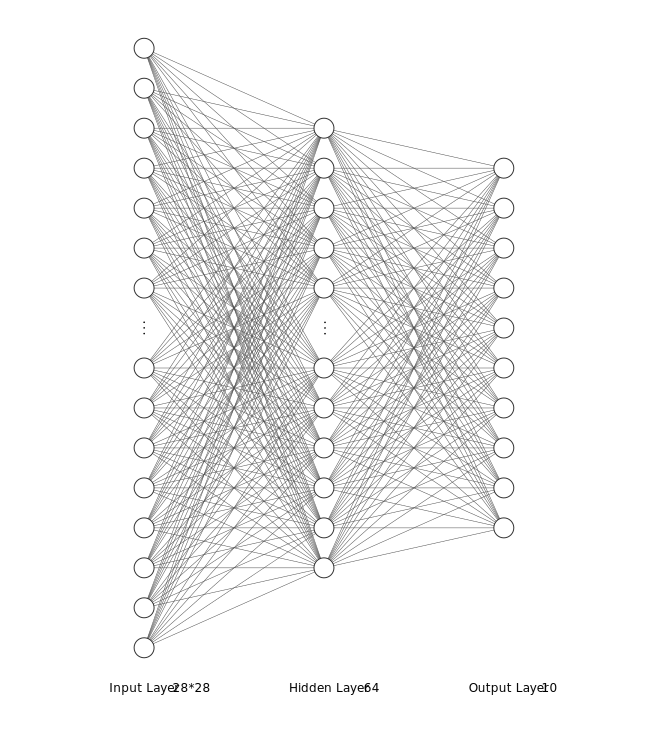

In [1]:
from IPython.display import SVG
SVG('assets/fcnn-28x28-64-10.svg')

In [768]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.fc1 = torch.nn.Linear(input_dim, 64)
        self.fc2 = torch.nn.Linear(64, output_dim)

    def forward(self, x):
        # activation function
        # activation = torch.sigmoid # 70%
        activation = torch.relu # 73%
        # activation = torch.nn.functional.leaky_relu # 77%
        # activation = torch.nn.functional.gelu # 82%
        # activation = torch.tanh # 84%
        # no activation function: 82%

        x = activation(self.fc1(x))
        x = self.fc2(x)
        return torch.log_softmax(x, dim=1)

In [769]:
n_iters = 3000
epochs = int(n_iters / (len(train_set) / batch_size))
input_dim = 28*28
output_dim = 10
lr_rate = 0.01

In [770]:
model = LogisticRegression(input_dim, output_dim)

Jetzt initialisieren wir die Loss class und den Optimizer (Stochastic Gradient Descent).

In [771]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr_rate)

In [772]:
from torch.autograd import Variable
import numpy as np

def calculate_accuracy(loader):
    correct = 0
    total = 0
    for images_test, labels_test in loader:
        images_test = Variable(images_test.view(-1, 28*28))
        outputs = model(images_test)
        _, predicted = torch.max(outputs.data, 1)
        total += labels_test.size(0)
        correct += (predicted == labels_test).sum()
    acc = correct.item() / total
    return acc

accuracy_steps = 250
accuracies = np.empty(int(n_iters / accuracy_steps))

print(model)

for epoch in range(epochs):
    for i, (images, labels) in enumerate(train_loader):
        # we use torch.autograd.Variable for backpropagation
        images = Variable(images.view(-1, 28 * 28))
        labels = Variable(labels)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        iteration = epoch * len(train_loader) + i
        if iteration % accuracy_steps == 0:
            test_accuracy = calculate_accuracy(test_loader)
            accuracies[int(iteration / accuracy_steps)] = test_accuracy

            print(f"Iteration: {iteration}. Loss: {loss.item():.5f}. Test Accuracy: {test_accuracy:.3f}.")
print(f"Final accuracy: {calculate_accuracy(test_loader)}")

LogisticRegression(
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)
5
Iteration: 0. Loss: 2.30462. Test Accuracy: 0.103.
Iteration: 250. Loss: 1.79649. Test Accuracy: 0.672.
Iteration: 500. Loss: 1.01611. Test Accuracy: 0.791.
Iteration: 750. Loss: 0.65188. Test Accuracy: 0.835.
Iteration: 1000. Loss: 0.56011. Test Accuracy: 0.862.
Iteration: 1250. Loss: 0.48724. Test Accuracy: 0.875.
Iteration: 1500. Loss: 0.36060. Test Accuracy: 0.883.
Iteration: 1750. Loss: 0.33541. Test Accuracy: 0.889.
Iteration: 2000. Loss: 0.44405. Test Accuracy: 0.893.
Iteration: 2250. Loss: 0.32313. Test Accuracy: 0.899.
Iteration: 2500. Loss: 0.48706. Test Accuracy: 0.900.
Iteration: 2750. Loss: 0.30016. Test Accuracy: 0.902.
Final accuracy: 0.9038


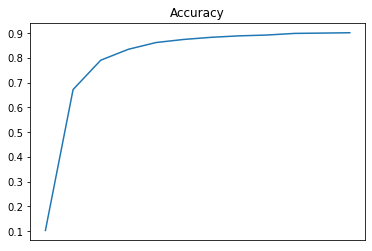

In [773]:
import matplotlib.pyplot as plt

plt.plot(accuracies)
plt.gca().axes.xaxis.set_visible(False)
plt.title("Accuracy")
plt.xlabel("")
plt.show()